<a href="https://colab.research.google.com/github/jaygo-kr/brunch/blob/master/03_03_sentiment_and_association_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 드라마 대본 감성분석, 연관분석, 토픽추출

* 이전 노트에서 정제한 대본 자료의 문장들로 대사의 감성분석, 연관분석, 토픽 추출을 해보자
1. 정제한 대본 파일 불러오기
2. 감성분석
3. 연관분석
4. 토픽추출

In [1]:
import os
import numpy as np
import pandas as pd
from google.colab import files, drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
DATA_PATH = './gdrive/My Drive/share/suwon study/script/JAY완료/' # 대본 데이터
TRAIN_PATH = './gdrive/My Drive/share/suwon study/sentiment/' # 네이버 영화 리뷰 감성데이터

In [3]:
os.listdir(DATA_PATH)[:5]

['W+제11회+대본.csv',
 'W+제12회+대본.csv',
 'W+제13회+대본.csv',
 'W+제15회+대본.csv',
 'W+제4회+대본.csv']

In [4]:
os.listdir(TRAIN_PATH)

['ratings.txt',
 'ratings_test.txt',
 'ratings_train.txt',
 'train.csv',
 'test.csv',
 'script.csv']

## 감성분석
* 네이버 감성분석 데이터로 감성분석을 위한 모델 학습시키기(https://github.com/e9t/nsmc/)

### 모델학습

In [0]:
senti = pd.read_csv(TRAIN_PATH + 'ratings.txt', sep='\t') # txt 파일 구분자 \t 기준으로 불러오기

In [6]:
senti # 네이버 영화 리뷰를 바탕으로 제작된 감성 데이터 셋이다. 긍정은 1, 부정은 0

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1
...,...,...,...
199995,8963373,포켓 몬스터 짜가 ㅡㅡ;;,0
199996,3302770,쓰.레.기,0
199997,5458175,완전 사이코영화. 마지막은 더욱더 이 영화의질을 떨어트린다.,0
199998,6908648,왜난 재미없었지 ㅠㅠ 라따뚜이 보고나서 스머프 봐서 그런가 ㅋㅋ,0


In [0]:
train_df = pd.read_csv(TRAIN_PATH + 'ratings_train.txt', sep='\t')
test_df = pd.read_csv(TRAIN_PATH + 'ratings_test.txt', sep='\t')

In [8]:
train_df.shape, test_df.shape

((150000, 3), (50000, 3))

In [9]:
# 한글 태깅을 위한 패키지 설치
! pip install konlpy

In [0]:
from konlpy.tag import Okt
tagger = Okt()

In [0]:
# 형태소  태깅에 장시간이 소요됨으로 한번 시행 후 저장하여 활용
#train_df['pos'] = train_df['document'].map(lambda x : tagger.pos(str(x), norm=True, stem=True))
#test_df['pos'] = test_df['document'].map(lambda x : tagger.pos(str(x), norm=True, stem=True))
#train_df.to_csv(TRAIN_PATH + 'train.csv', index=False)
#test_df.to_csv(TRAIN_PATH + 'test.csv', index=False)

In [0]:
train_df = pd.read_csv(TRAIN_PATH + 'train.csv')
test_df = pd.read_csv(TRAIN_PATH + 'test.csv')

In [13]:
train_df.head()

,id,document,label,pos
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,"[('아', 'Exclamation'), ('더빙', 'Noun'), ('..', ..."
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,"[('흠', 'Noun'), ('...', 'Punctuation'), ('포스터'..."
2,10265843,너무재밓었다그래서보는것을추천한다,0,"[('너', 'Modifier'), ('무재', 'Noun'), ('밓었', 'No..."
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,"[('교도소', 'Noun'), ('이야기', 'Noun'), ('구먼', 'Nou..."
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,"[('사이', 'Modifier'), ('몬페', 'Noun'), ('그', 'De..."


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer # 벡터화

In [0]:
vectorizer = TfidfVectorizer(max_features=5000) # colab RAM이 부족하여 5천개로 타협
vectorizer.fit(train_df['pos'])
train_X = vectorizer.transform(train_df['pos'])
test_X = vectorizer.transform(test_df['pos'])

In [16]:
len(vectorizer.get_feature_names())

5000

In [0]:
train_y = train_df['label']
test_y = test_df['label']

In [18]:
# 모델링
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(5000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
             loss=losses.binary_crossentropy,
             metrics=[metrics.binary_accuracy])

model.fit(train_X, train_y, epochs=10, batch_size=512)
results = model.evaluate(test_X, test_y) # 83%의 정확도 확보

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 150000 samples
Epoch 1/10
150000/150000 [==============================] - 4s 27us/sample - loss: 0.4175 - binary_accuracy: 0.8165
Epoch 2/10
150000/150000 [==============================] - 4s 25us/sample - loss: 0.3619 - binary_accuracy: 0.8385
Epoch 3/10
150000/150000 [==============================] - 4s 25us/sample - loss: 0.3521 - binary_accuracy: 0.8434
Epoch 4/10
150000/150000 [==============================] - 4s 25us/sample - loss: 0.3424 - binary_accuracy: 0.8471
Epoch 5/10
150000/150000 [==============================] - 4s 25us/sample - loss: 0.3351 - binary_accuracy: 0.8516
Epoch 6/10
150000/150000 [==============================] - 4s 25us/sample - loss: 0.3290 - binary_accuracy: 0.8558
Epoch 7/10
150000/150000 [==============================] - 4s 25us/sample - loss: 0.3234 - binary_accura

### 대본 감성분석
* 위에서 학습한 모델을 대본에 적용

In [0]:
script_df = pd.read_csv(DATA_PATH + 'W+제1회+대본.csv')

In [20]:
script_df.head()

,act,content
0,씬/1,아테네 올림픽 자료화면 인서트 \n
1,지문,자막 – 2004년 8월. 아테네 올림픽\n한국 국가대표 경기 생중계 자료화면.\n...
2,씬/2,"방송 스튜디오 (과거, 밤)\n"
3,지문,올림픽 중계 스튜디오. 아테네 올림픽 엠블럼과 마스코트를 배경으로 남자 MC가 진행...
4,MC,"네, 잠시 종목을 바꿔보겠습니다. 지금 사격 경기장에서는 50미터 권총 남자 결선이..."


In [0]:
from konlpy.tag import Okt
tagger = Okt()

In [0]:
#script_df['pos'] = script_df['content'].map(lambda x : tagger.pos(str(x), norm=True, stem=True))
#script_df.to_csv(TRAIN_PATH + 'script.csv', index=False)

In [0]:
script_df = pd.read_csv(TRAIN_PATH + 'script.csv')

In [0]:
script_X = vectorizer.transform(script_df['pos'])

In [0]:
script_y = model.predict(script_X)

In [0]:
script_df['label'] = script_y

In [27]:
script_df.sort_values(by=['label'])

,act,content,pos,label
370,지문,쓰레기와 주류 상자들이 쌓여있는 좁은 복도. 요란한 음악소리가 멀리 들려오고. 연주...,"[('쓰레기', 'Noun'), ('와', 'Josa'), ('주류', 'Noun'...",0.011458
293,지문,조금 전과 풍경은 그대로. 앉아있던 성무만 사라지고 없는.\n삐딱하게 돌아간 의자....,"[('조금', 'Noun'), ('전과', 'Noun'), ('풍경', 'Noun'...",0.012698
182,박교수,너도 그림이나 그리지 그랬어? 재주도 없는 의사공부 하느라 뭔 고생이야?\n,"[('너', 'Noun'), ('도', 'Josa'), ('그림', 'Noun'),...",0.013584
75,C#1,뉴스룸 (밤)\n남자 앵커가 뉴스 진행 중이다. \n강철의 얼굴과 부모와 여동생 등...,"[('뉴스룸', 'Noun'), ('(', 'Punctuation'), ('밤', ...",0.016045
199,연주,(황당)\n,"[('(', 'Punctuation'), ('황당', 'Noun'), (')', '...",0.018282
...,...,...,...,...
449,지문,"강철, 매니저의 수선스런 목소리가 환청처럼 들리는 와중에, 시야에 대원들의 사이로 ...","[('강철', 'Noun'), (',', 'Punctuation'), ('매니저',...",0.994697
280,연주,(? 돌아보는)\n,"[('(?', 'Punctuation'), ('돌아보다', 'Verb'), (')'...",0.995663
181,연주,"(늘 갈구는 방식이다, 울컥) 죄송합니다. 고작 오연주라서.\n","[('(', 'Punctuation'), ('늘', 'Noun'), ('갈구다', ...",0.997181
216,석범,교수님.. 이거 싸인.. (다가오며 놀라 연주에게 눈빛으로 뭔 일인지 묻는데)\n,"[('교수', 'Noun'), ('님', 'Suffix'), ('..', 'Punc...",0.997608


> 라벨이 0에 가까울수록 긍정, 1에 가까울수록 부정 으로 학습된 모델을 활용 하였으나, 이를 대본에 적용해본 결과 잘 맞지 않는다.
대화체의 영화 리뷰와 정제되어 있는 대본과는 쓰는 단어의 차이가 나기 때문으로 판단된다.

## 대사 연관분석
* 대사들을 벡터화 하고 그 거리를 계산하여 연관성을 분석

In [0]:
main_actor = ['연주','수봉','박교수','강철','소희','석범'] # 이전 분석에서 추출한 주요 인물들 : 연주 139 수봉 62 박교수 41 강철 28 소희 19 석범 13

In [0]:
script_by_actor = pd.DataFrame(index = main_actor)

In [0]:
for actor in main_actor: # 인물별로 대사들의 품사 테깅 데이터를 통합
  script_by_actor.loc[actor, 'scripts'] = script_df[script_df['act'] == actor]['pos'].str.cat()

In [32]:
script_by_actor

,scripts
연주,"[('(', 'Punctuation'), ('겨우', 'Noun'), ('보고', ..."
수봉,"[('(', 'Punctuation'), ('E', 'Alpha'), (')', '..."
박교수,"[('들어오다', 'Verb'), ('.', 'Punctuation'), ('\n'..."
강철,"[('......', 'Punctuation')][('.....!', 'Punctu..."
소희,"[('아뇨', 'Noun'), ('.', 'Punctuation'), ('일대', ..."
석범,"[('(!!', 'Punctuation'), ('그', 'Noun'), ('소리',..."


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
corvec = TfidfVectorizer()
script_vec = corvec.fit_transform(script_by_actor['scripts'])

In [0]:
import scipy # 벡터거리 계산 함수 https://steemit.com/kr/@anpigon/5
def dist_norm(v1, v2):
    v1_normalized = v1/scipy.sparse.linalg.norm(v1)
    v2_normalized = v2/scipy.sparse.linalg.norm(v2)
    delta = v1_normalized - v2_normalized
    return scipy.sparse.linalg.norm(delta)

In [0]:
cor_mat = np.zeros([6,6]) # 계산된 값을 상관 행렬로 정리
for i in range(6):
  for j in range(6):
    cor_mat[i,j] = dist_norm(script_vec[i], script_vec[j])

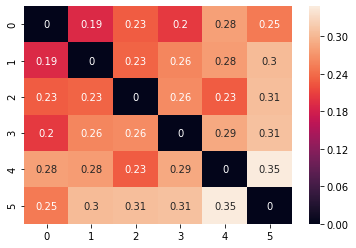

In [37]:
import seaborn as sns
sns.heatmap(cor_mat, annot=True) # ['연주','수봉','박교수','강철','소희','석범']

> 수치가 낮을수록 유사함을 나타낸다. 연산을 토대로 보면 '연주'와 '수봉'이 가장 유사한 말을 쓰고 있고,'소희'와 '석범'이 가장 다른 말을 쓰고 있다고 볼 수 있다.

In [38]:
script_df[(script_df['act']=="연주") | (script_df['act']=="수봉")].tail(10)

,act,content,pos,label
566,연주,(머리를 마구 헝클며) 이거 아빠가 그리는 게 아니야..!!\n,"[('(', 'Punctuation'), ('머리', 'Noun'), ('를', '...",0.152606
567,수봉,(? 이해 못하고) 그럼 누가 그려요? \n,"[('(?', 'Punctuation'), ('이해', 'Noun'), ('못', ...",0.294680
568,연주,이건 저절로 생겨난 거야..! 내가 강철을 살려내면서!! \n,"[('이', 'Determiner'), ('것', 'Noun'), ('은', 'Jo...",0.304304
569,수봉,에?\n,"[('에', 'Josa'), ('?', 'Punctuation'), ('\n', '...",0.757596
570,연주,죽어야 될 강철이 살아나면서 스토리가 저절로 진행되고 있는 거라고!\n,"[('죽다', 'Verb'), ('되다', 'Verb'), ('강철', 'Noun'...",0.523396
571,수봉,(어이없는) 누나 저번부터 뭔 이상한 소리를 자꾸..\n,"[('(', 'Punctuation'), ('어이없다', 'Adjective'), ...",0.032150
572,연주,내 말이 무슨 말인지 모르겠어? 강철이 살아있다고!! 살아서 나를 찾고 있어!!\n...,"[('내', 'Noun'), ('말', 'Noun'), ('이', 'Josa'), ...",0.893146
573,수봉,(E) 누나 좀 진정하고.. 난 뭔 소리를 하는 건지\n,"[('(', 'Punctuation'), ('E', 'Alpha'), (')', '...",0.505930
575,연주,(살아있는 사람에게 말 걸 듯) 왜 나를 찾아 당신...? 날 찾아서 어쩌려고...?\n,"[('(', 'Punctuation'), ('살다', 'Verb'), ('사람', ...",0.841711
577,연주,왜 내가 당신 인생의 키가 되는데..?\n,"[('왜', 'Noun'), ('내', 'Noun'), ('가', 'Josa'), ...",0.718346


> 비슷해 보이기도 하고...사실 잘 모르겠다

## 토픽 추출

In [0]:
from gensim.summarization.summarizer import summarize

In [0]:
text = script_df['content'].str.cat(sep=' ')

In [41]:
print(summarize(text, word_count=30)) # 이대로만 보면 살벌한 느낌의 드라마이다...

2위 선수, 마음대로 안 되자 작게 한 숨 쉬며 고개를 젓는데 강철의 얼굴에는 그제야 비로소 소년다운 미소가 싱긋 돈다.
쓰러진 강철의 장면에 붉은 피를 채워 넣으며 미소 짓고 있는 성무의 모습이 보이고..


In [0]:
text_yunju = script_df[script_df['act'] == '연주']['content'].str.cat(sep=' ')

In [43]:
print(summarize(text_yunju, word_count=30))

(중얼) 웬일이야~ 미친개가 만화 좋아하는 줄 진즉 알았으면 인생이 편했을텐데~ 그래도 이제라도 안 게 어디야?
(반갑게) 수봉아~ 오랜만이다~
(황당한) 여기가 어디야..?
(버럭) 이봐요!!
강철이 누군데..?
너는 경찰에 신고한다고 나가고
강철이 살아있다고!!


In [44]:
main_actor

['연주', '수봉', '박교수', '강철', '소희', '석범']

In [45]:
for actor in main_actor:
  print("------------------")
  print("{}의 대사 요약\n".format(actor))
  text_actor = script_df[script_df['act'] == actor]['content'].str.cat(sep=' ')
  print(summarize(text_actor, word_count=30))


------------------
연주의 대사 요약

(중얼) 웬일이야~ 미친개가 만화 좋아하는 줄 진즉 알았으면 인생이 편했을텐데~ 그래도 이제라도 안 게 어디야?
(반갑게) 수봉아~ 오랜만이다~
(황당한) 여기가 어디야..?
(버럭) 이봐요!!
강철이 누군데..?
너는 경찰에 신고한다고 나가고
강철이 살아있다고!!
------------------
수봉의 대사 요약

근데 누나 되게 이상한 게 뭐냐면요, 우리가 어제 밖에서 밤샘 작업을 했는데 한 번도 이 방에서 나오시질 않았거든요?
우리가 얼마나 반대했다구요.
선생님 속을 내가 어떻게 알아요?
어디서 보내신 건진 모르겠지만 하여튼 지금 막 보내셨어요!
------------------
박교수의 대사 요약

아버지는 무려 오성무 작가님이신데 딸은 왜 고작 오연주야??
(짜증나, 보던 핸드폰을 흔들며) 임마, 아버지가 딸 사랑하는 마음은 십분 이해하지만 말야, 만화 캐릭터를 이렇게 오연주라고 대놓고 해버리시면 나 같은 독자는 어떻게 보냐?
------------------
강철의 대사 요약

(구겨진 명함을 받아들고 읽는) 흉부외과 레지던트 오연주..?
아무래도 이 여자가 내 인생의 키를 쥔 거 같으니까.
내 존재의 이유.
내 존재의 이유를 밝혀줄 키가 그 여자 같아.
(진지하게) 오연주..
------------------
소희의 대사 요약

(그 말에 순간 기분 상하는) 대표님 인생의 키요..?
(눈 가늘게 뜨며) 근데 인생의 키라고요?
그게 아님 어떻게 처음 본 여자가 인생의 키가 되나요?
대표님 인생의 키가 될 여자는 결코 미인이 아니라고.
------------------
석범의 대사 요약

그 소리에 자동으로 벌떡 일어나는)
(혼비백산 전화 받는) 네 교수님!
석범입니다!
오연주요?
교수님 저도 좀 아는데요, 얘네 아버지가 얄짤 없으시더라구요.
(억울한) 교수님 이건 공정한 처사가 아니신 거 같은데요.
교수님?
교수님?


* 인물들의 대사를 추출하니 그 인물의 성향이 들어나는거 같긴 합니다.
위 요약들이 어떻게 추출되었는지에 대한 알고리즘은 https://excelsior-cjh.tistory.com/93